In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from _lib import load_curvecurator, plot_fit_type, plot_paired_fit_type, plot_fit, fit, to_p_space, from_p_space

# Increase plot resolution
plt.rcParams['figure.dpi'] = 200

In [2]:
# Color palette for the fit types
palette = sns.color_palette("tab10")
palette = {
    "Target": palette[0],
    "Off-target": palette[1],
    "Both": palette[2]
}

# Maximum distance from the target pEC50 that we consider for the target range.
RANGE_DELTA = 1

In [3]:
drugs = {
    "Afatinib": {
        'identifier': "10184653/2reps_only",
        'target_ec50_nm': 3,
        'target': "EGFR"
    },
    "Lapatinib": {
        "identifier": "208908",
        "target_ec50_nm": 65,
    },
    "PF-3758309": {
        "identifier": "25227462",
        'target_ec50_nm': 119,
        'target': 'PAK4'
    },
    "Dasatinib": {
        "identifier": "3062316",
        'target_ec50_nm': 5,
    },
    "92131101": {
        "identifier": "92131101",
        'target_ec50_nm': 10,
    },
    "Tipifarnib": {
        "identifier": "159324",
        'target_ec50_nm': 40,
    },
    "Docetaxel": {
        "identifier": "9877265",
        'target_ec50_nm': 50,
    },
    "168312962": {
        "identifier": "168312962",
        'target_ec50_nm': 40,
    },
    "Selumetinib": {
        "identifier": "10127622",
        'target_ec50_nm': 200,
    },
    "11364421": {
        "identifier": "11364421",
        'target_ec50_nm': 8,
    },
    "Bleomycin": {
        "identifier": "46930982",
        'target_ec50_nm': 50,
    },
    "Alisertib": {
        "identifier": "24771867",
        'target_ec50_nm': 30,
    },
    "Oligomycin A": {
        "identifier": "6364620",
        'target_ec50_nm': 30,
    },
    "Trametinib": {
        "identifier": "11707110",
        'target_ec50_nm': 20,
    },
    "Leptomycin B": {
        "identifier": "6917907",
        'target_ec50_nm': 30,
    },
    "Vincristine": {
        "identifier": "5388993",
        'target_ec50_nm': 100,
    },
    "Idelalisib": {
        "identifier": "11625818",
        'target_ec50_nm': 80,
    },
    "Rapamycin": {
        "identifier": "5284616",
        'target_ec50_nm': 30,
    },
}

In [4]:
# Select one of the drugs from the list above
drug = "Dasatinib"

# Load the associated data
df_curvecurator, df_doses = load_curvecurator(drugs[drug]['identifier'])
target = drugs[drug].get('target', None)
target_pec50 = to_p_space(drugs[drug]['target_ec50_nm'] / 1e9)
target_pec50_range = np.array([target_pec50 - RANGE_DELTA, target_pec50 + RANGE_DELTA])
target_ec50_range = from_p_space(target_pec50_range)

# pEC50 distribution (wrt the target pEC50)

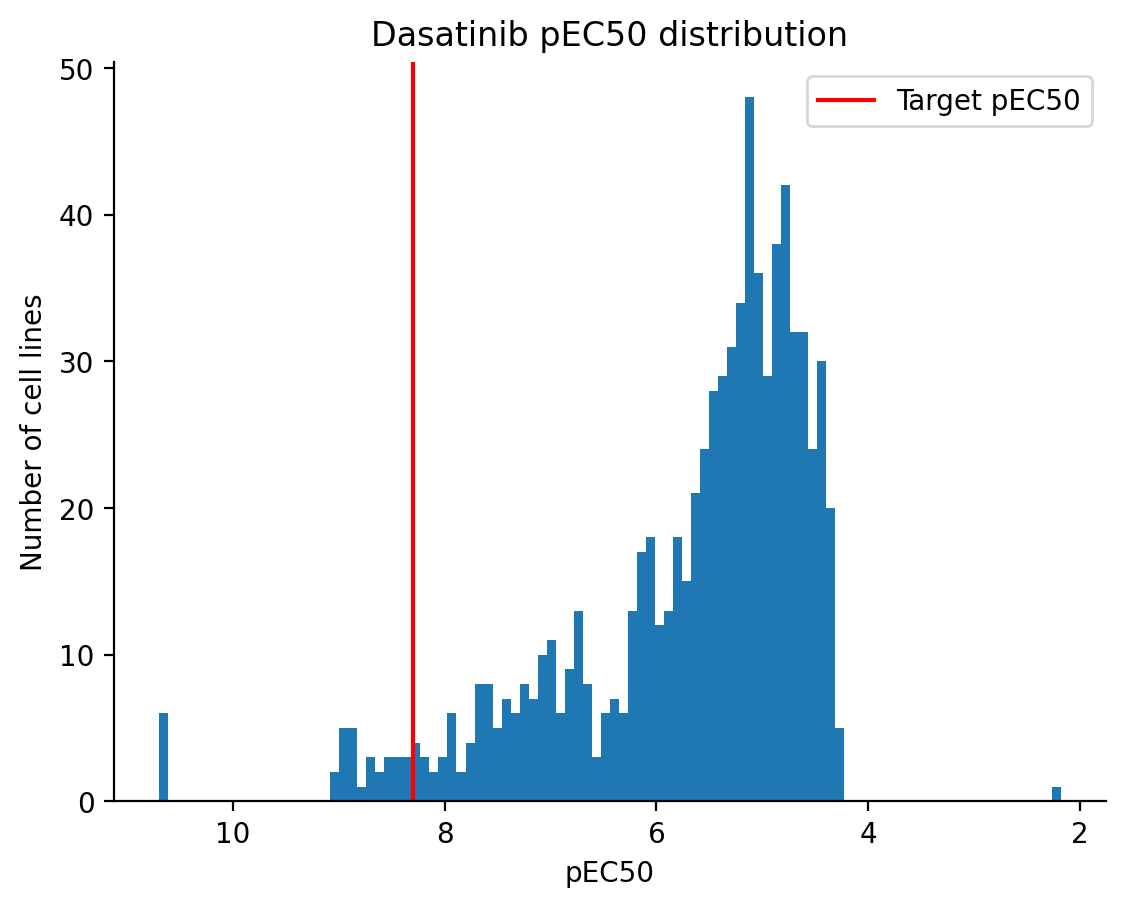

In [ ]:
df_curvecurator['pEC50'].hist(bins=100)

plt.grid(False)
sns.despine()
plt.axvline(target_pec50, color="red", label=f"Target ({target}) pEC50" if target else "Target pEC50")

# Set x-axis label
plt.xlabel("pEC50")
# Set y-axis label
plt.ylabel("Number of cell lines")
plt.title(f"{drug} pEC50 distribution")
plt.legend()
plt.gca().invert_xaxis()

# Perform two-step fitting

This calculates a lot of the metrics, that are used in the plots below.

Fitting can take a couple of minutes, depending on the number of cell lines.

In [6]:
df_curvecurator = fit(df_curvecurator, df_doses, target_pec50_range)

# Investigate the results

## Validate that the effect span is high where we expect it
We expect the effect span to be high between the target pEC50 and the off-target effects.

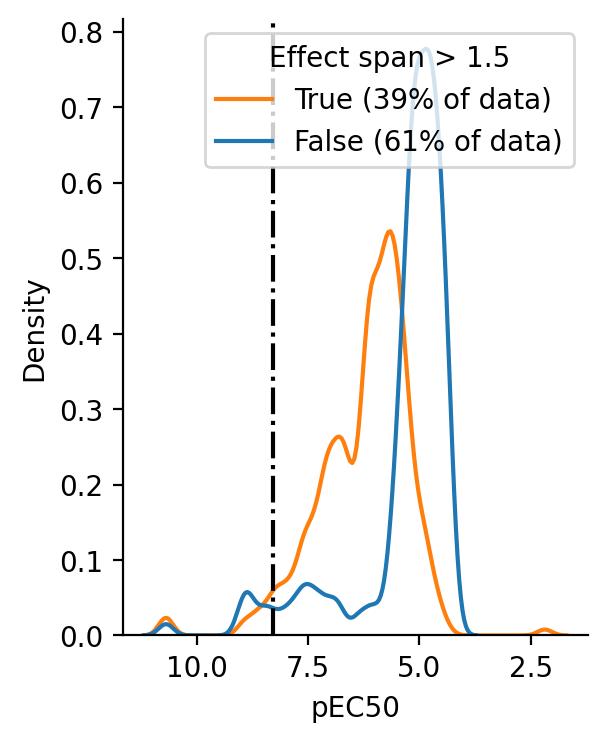

In [7]:
sns.kdeplot(df_curvecurator, x="pEC50", hue="Effect span > 1.5", common_norm=False, bw_adjust=0.5)
sns.despine()
plt.axvline(target_pec50, color="black", linestyle="-.", label=f"Target ({target}) pEC50" if target else "Target pEC50")
pct_false = 100 * (1-df_curvecurator["Effect span > 1.5"].mean())
pct_true = 100 * df_curvecurator["Effect span > 1.5"].mean()
# Change legend labels
plt.legend(title="Effect span > 1.5", labels=[f"True ({pct_true:.0f}% of data)", f"False ({pct_false:.0f}% of data)"])
plt.gcf().set_size_inches(3, 4)
plt.gca().invert_xaxis()

## Prove that the two-step model performs better than the single-step model
The `sigmoid_diff` is calculated as `r2(double)-r2(single)`.
If this is positive, the two-step model performs better than the single-step model.

<Axes: xlabel='sigmoid_diff', ylabel='Count'>

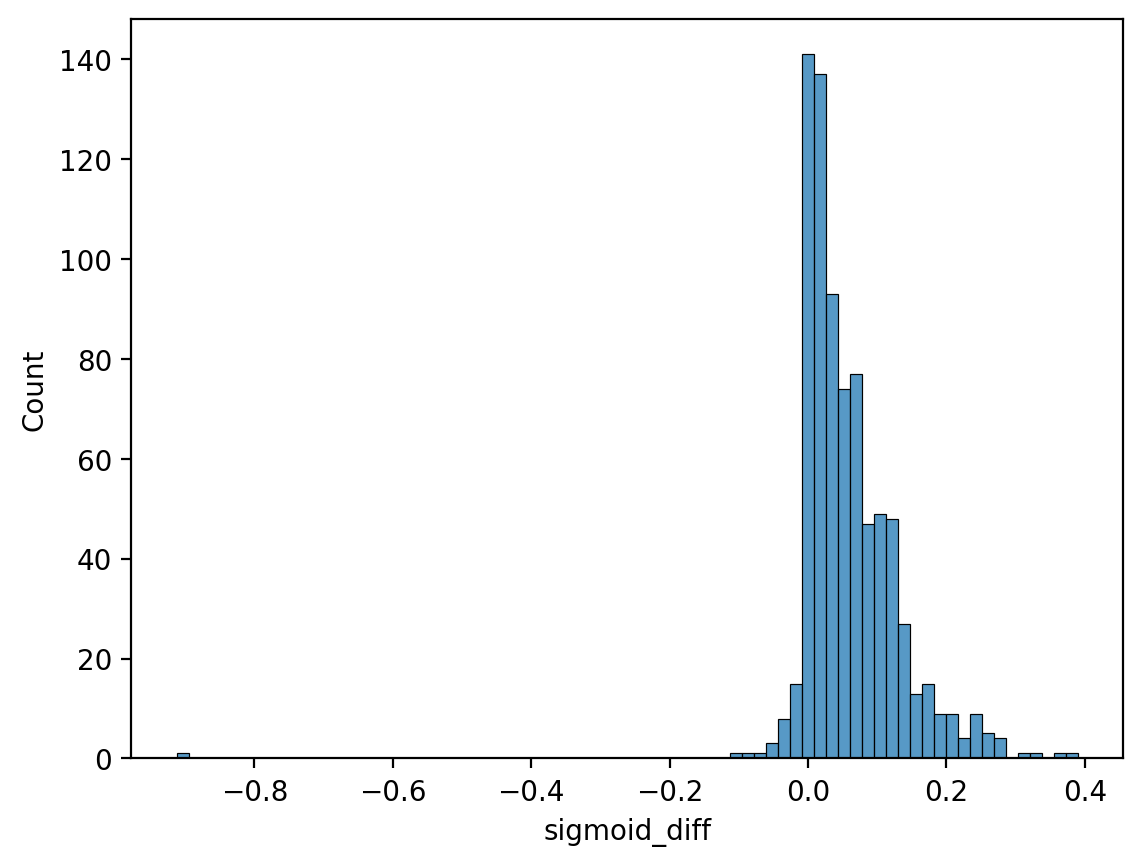

In [ ]:
sns.histplot(df_curvecurator, x="sigmoid_diff")

## Investigate some cases where the two-step model performs worse than the single-step model
Therefore we subset the data to only include cases where the two-step model performs worse than the single-step model.
Then we sort the data by ascending `sigmoid_diff`.

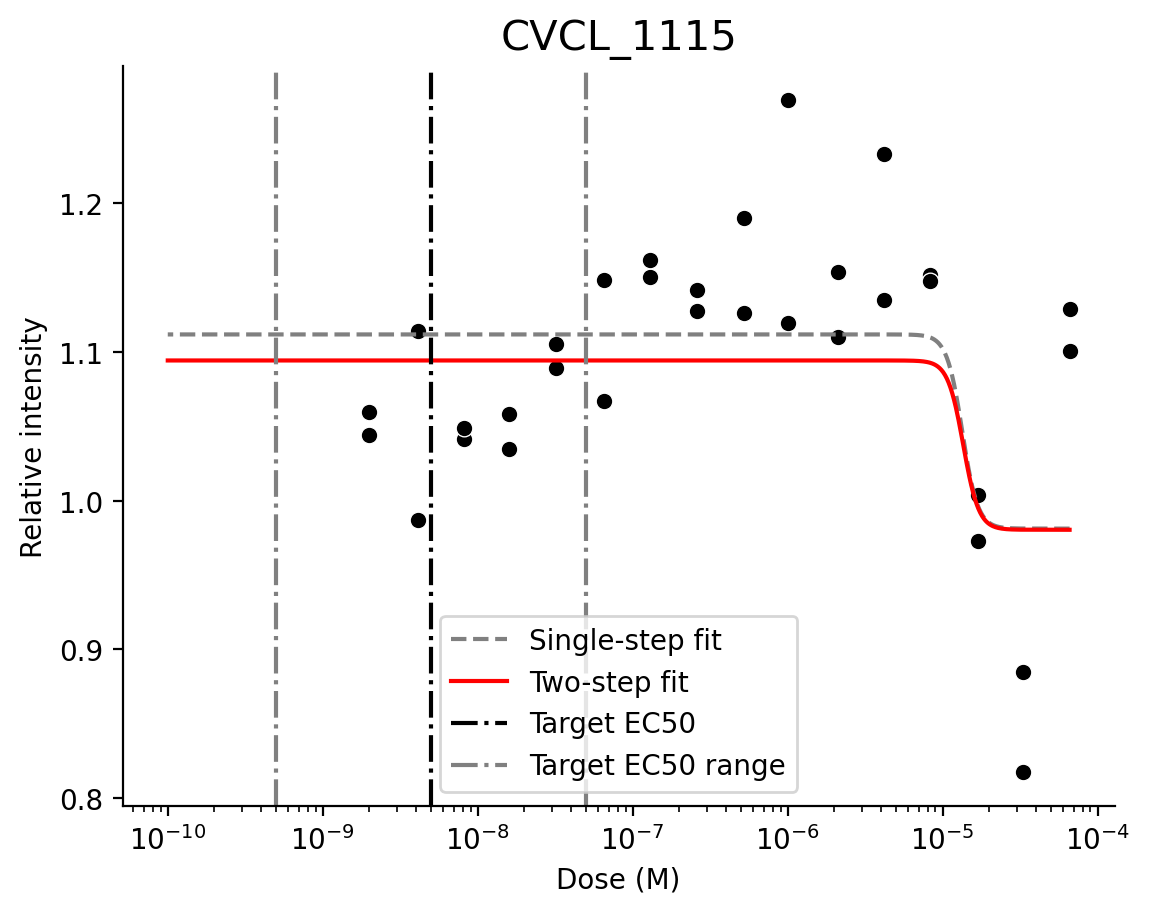

In [9]:
i = 1 # Rank of the cell line to plot (0 is the worst two-step fit, high values are better)
df_increasing_sigdiff = df_curvecurator[df_curvecurator["sigmoid_diff"] < 0.0].sort_values("sigmoid_diff", ascending=True)
plot_fit(df_curvecurator, df_doses, df_increasing_sigdiff.index[i], target_ec50_range)

# Visualize some interesting curves

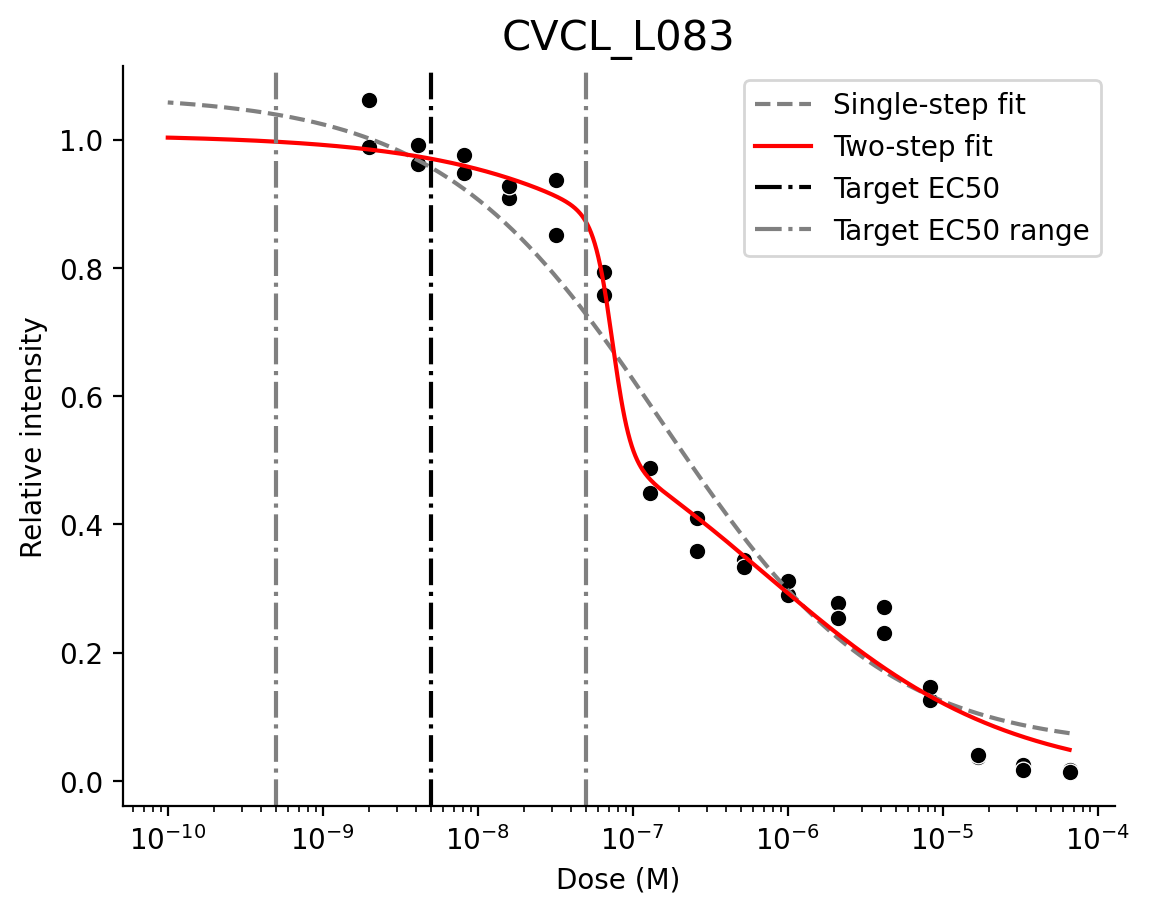

In [10]:
plot_fit(df_curvecurator, df_doses, "CVCL_L083", target_ec50_range)

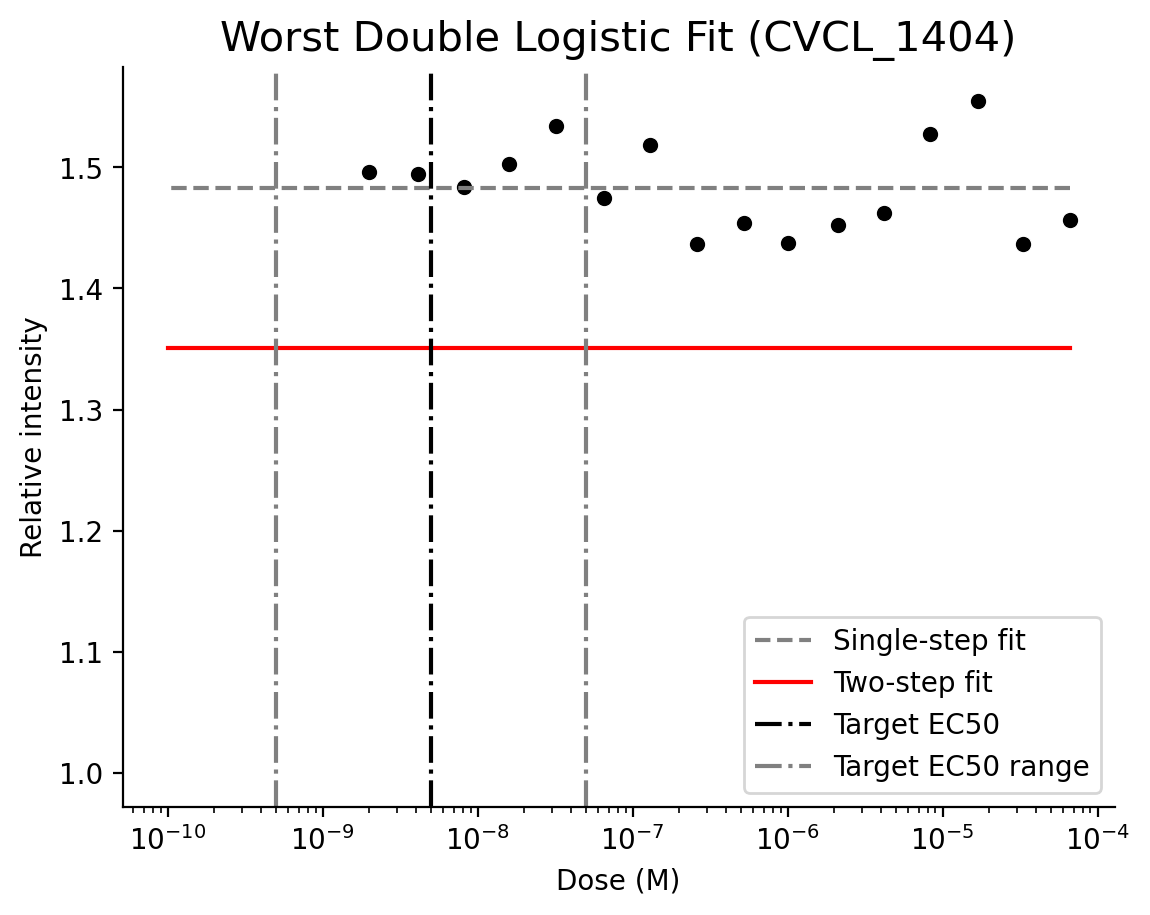

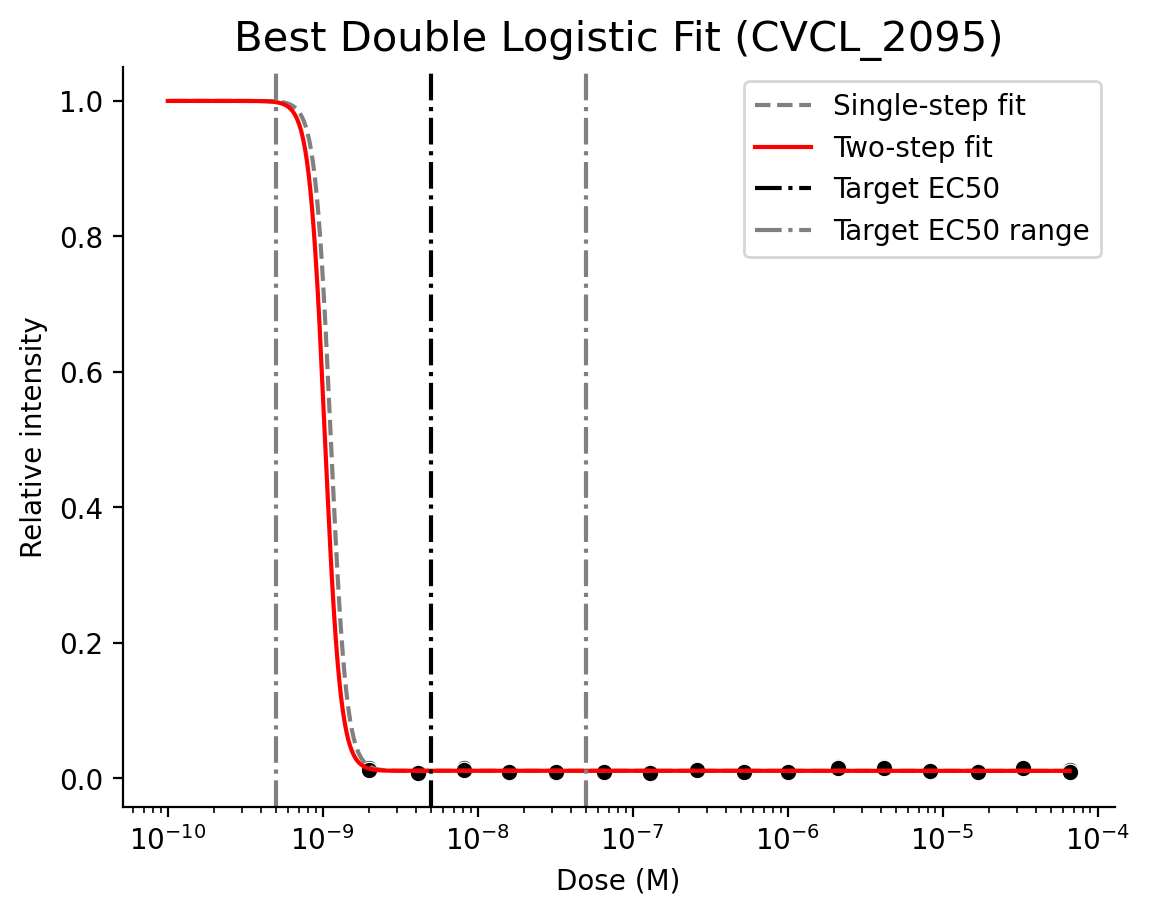

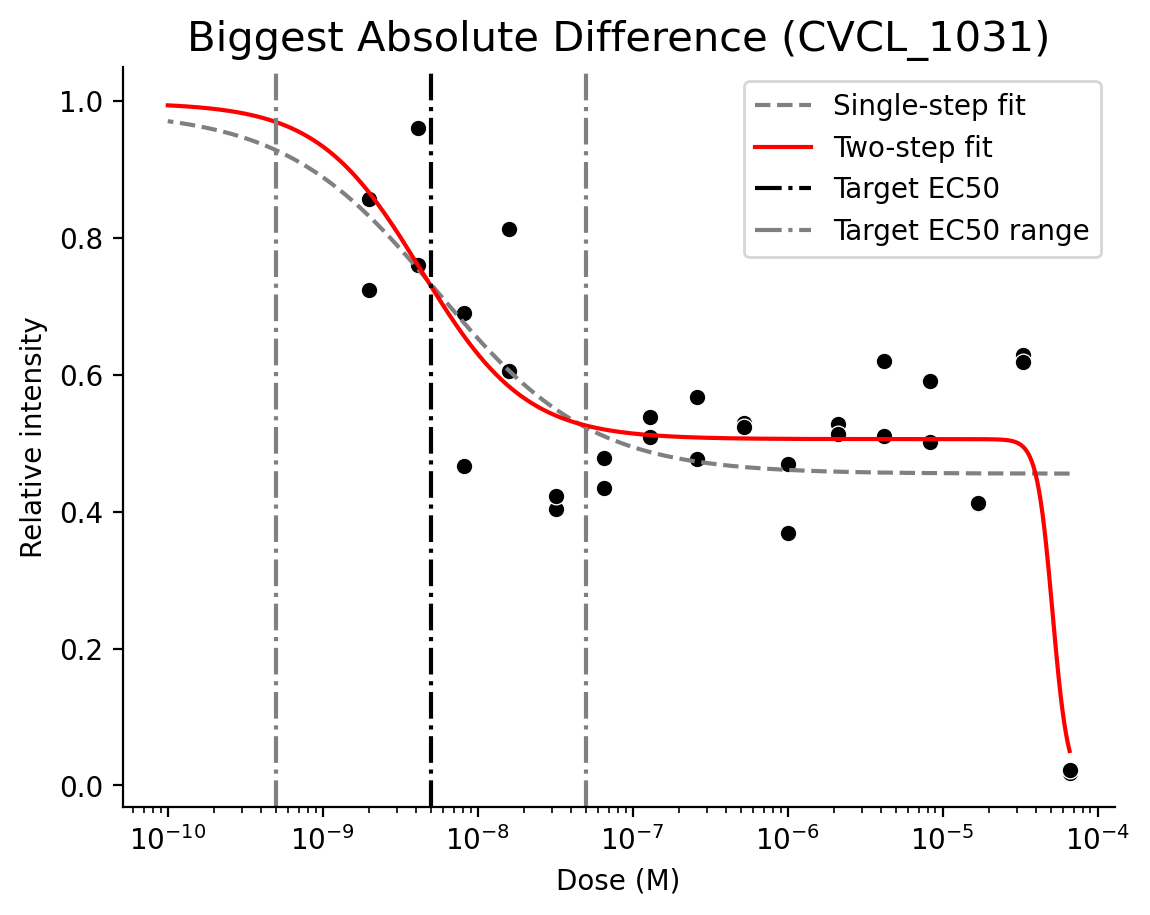

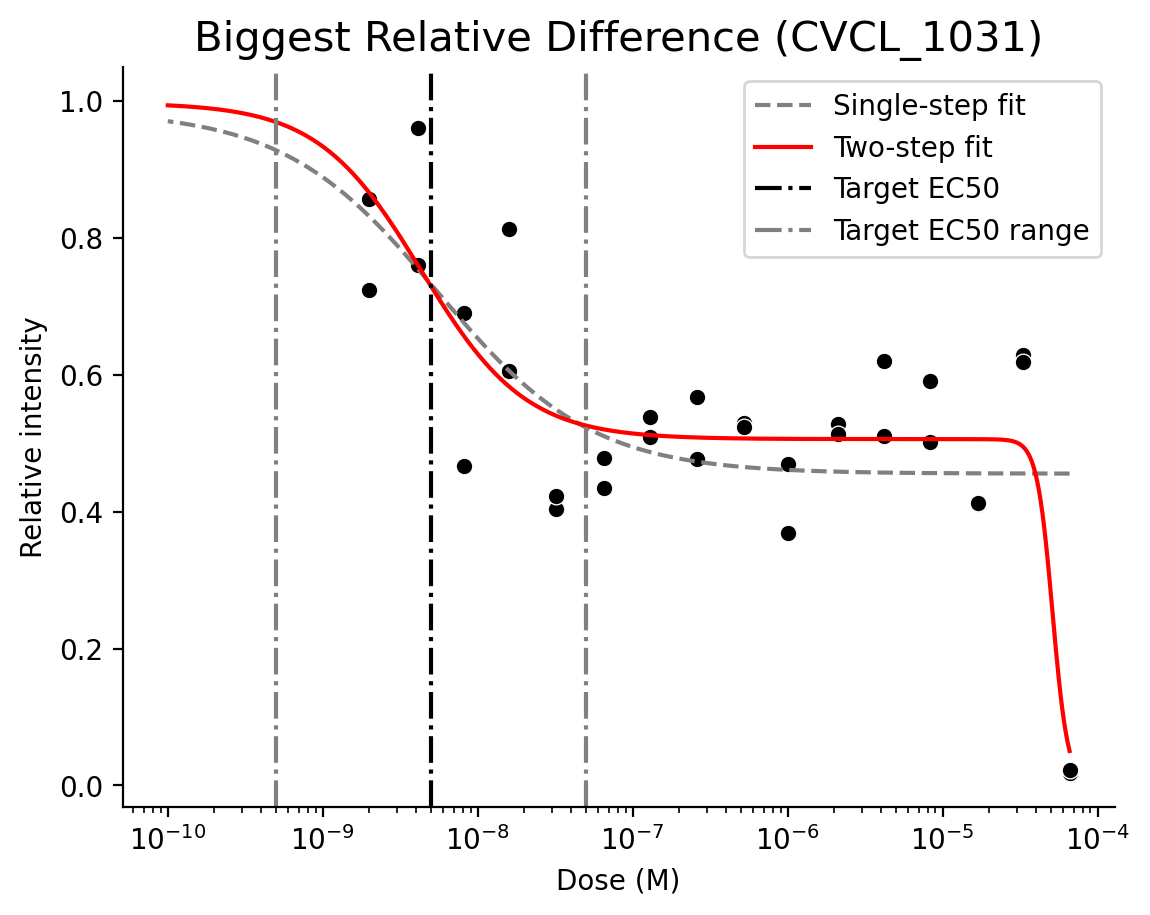

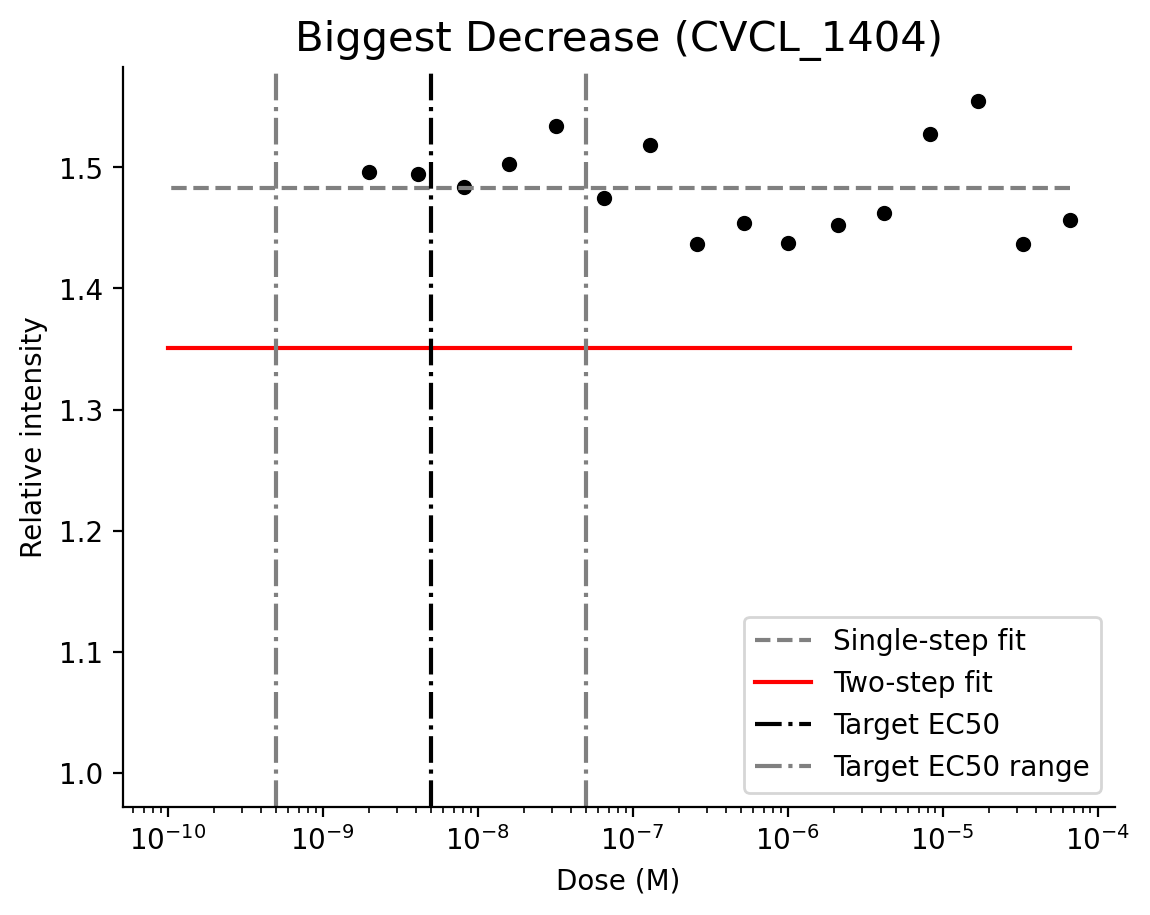

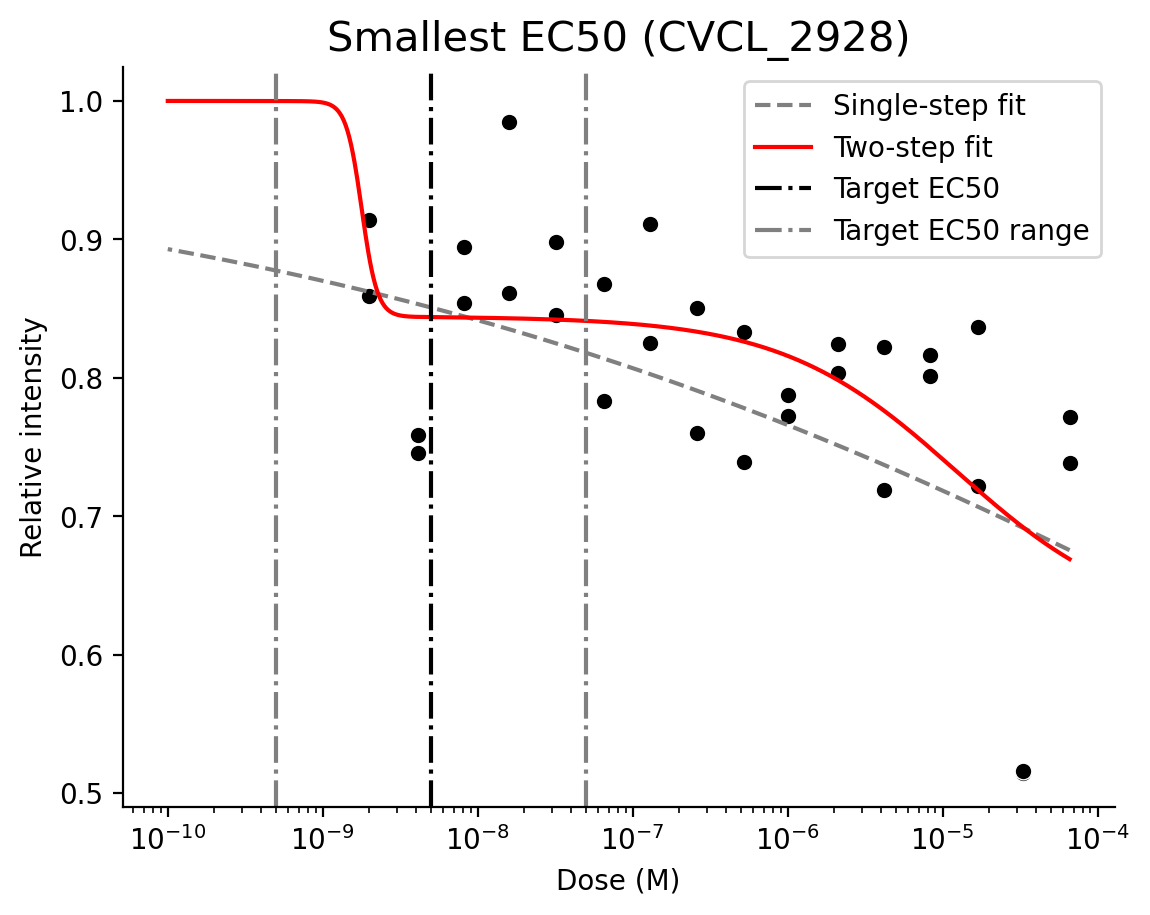

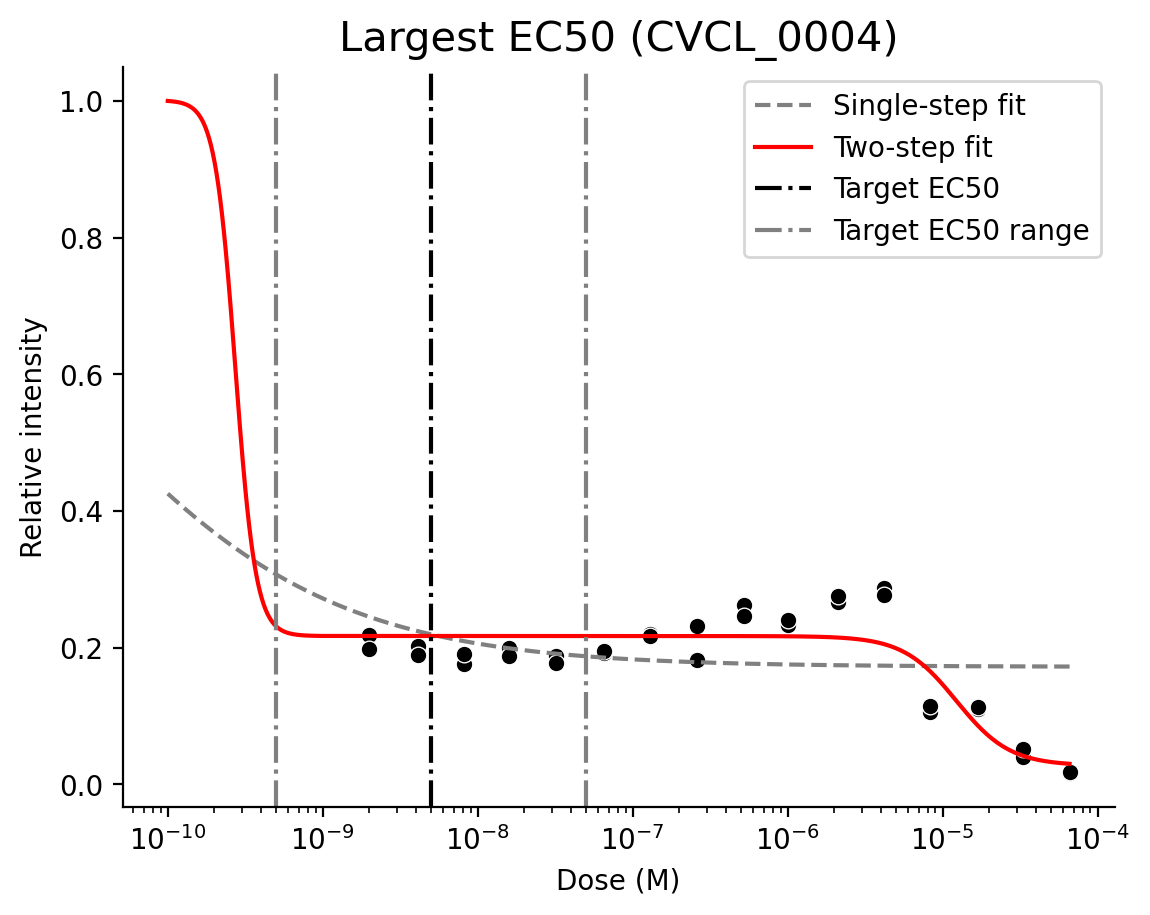

In [11]:
worst_single = df_curvecurator["single_r2"].idxmin()
best_single = df_curvecurator["single_r2"].idxmax()
worst_double = df_curvecurator["double_r2"].idxmin()
best_double = df_curvecurator["double_r2"].idxmax()
largest_diff_abs = df_curvecurator["sigmoid_diff"].idxmax()
largest_dec_abs = df_curvecurator["sigmoid_diff"].idxmin()
smallest_ec50 = df_curvecurator["pEC50"].idxmin()
largest_ec50 = df_curvecurator["pEC50"].idxmax()
largest_diff_rel = (df_curvecurator["sigmoid_diff"] / df_curvecurator["single_r2"]).idxmax()

plot_fit(df_curvecurator, df_doses, worst_double, target_ec50_range, title=f'Worst Double Logistic Fit ({worst_double})')
plot_fit(df_curvecurator, df_doses, best_double, target_ec50_range, title=f'Best Double Logistic Fit ({best_double})')
plot_fit(df_curvecurator, df_doses, largest_diff_abs, target_ec50_range, title=f'Biggest Absolute Difference ({largest_diff_abs})')
plot_fit(df_curvecurator, df_doses, largest_diff_rel, target_ec50_range, title=f'Biggest Relative Difference ({largest_diff_rel})')
plot_fit(df_curvecurator, df_doses, largest_dec_abs, target_ec50_range, title=f'Biggest Decrease ({largest_dec_abs})')
plot_fit(df_curvecurator, df_doses, smallest_ec50, target_ec50_range, title=f'Smallest EC50 ({smallest_ec50})')
plot_fit(df_curvecurator, df_doses, largest_ec50, target_ec50_range, title=f'Largest EC50 ({largest_ec50})')

# Check the fit type distribution

In [12]:
#https://stackoverflow.com/a/71515035/2901002
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}% ({v:d})'.format(pct, v=val)
        return my_format

Text(0.5, 0.98, 'Dasatinib')

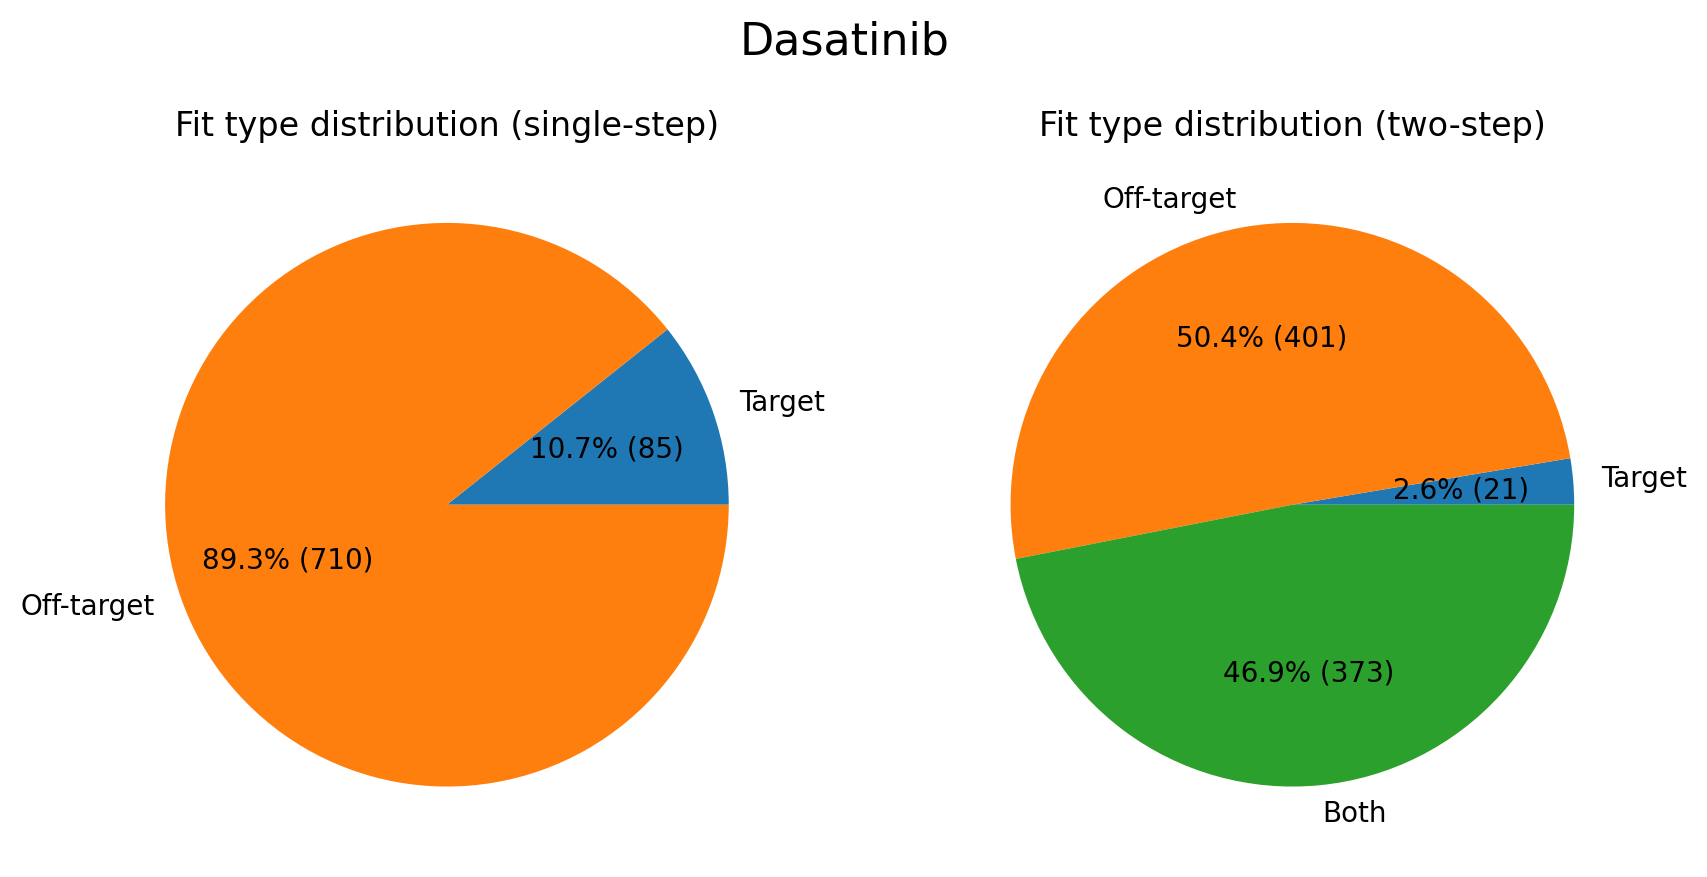

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

cols = ["Target", "Off-target", "Both"]

counts = df_curvecurator["Single fit type"].value_counts()
counts = counts.loc[[col for col in cols if col in counts.index]]
counts.plot.pie(autopct=autopct_format(counts), title="Fit type distribution (single-step)", ax=axs[0], colors=[palette[col] for col in counts.index])

# Show absolute values
counts = df_curvecurator["Double fit type"].value_counts()
counts = counts.loc[[col for col in cols if col in counts.index]]
counts.plot.pie(autopct=autopct_format(counts), title="Fit type distribution (two-step)", ax=axs[1], colors=[palette[col] for col in counts.index])

for ax in axs:
    # Remove y-axis label
    ax.set_ylabel('')

# Set global title
plt.suptitle(drug, fontsize=16)

## Check the effect of the two-step model on the pEC50 distribution

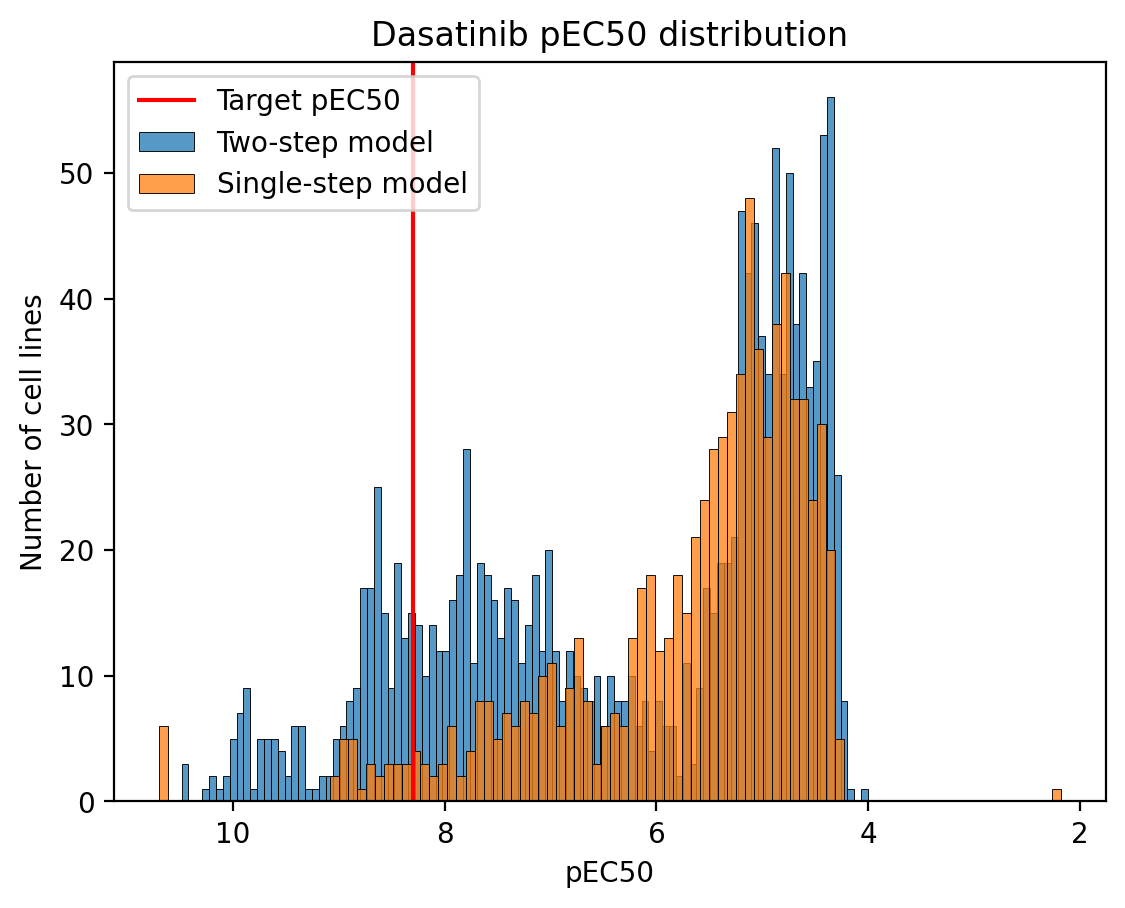

In [14]:
pec50s = df_curvecurator[df_curvecurator["double_pec50_1_substantial"]]["double_pec50_1"].to_list() \
    + df_curvecurator[df_curvecurator["double_pec50_2_substantial"]]["double_pec50_2"].to_list()
sns.histplot(pec50s, bins=100, label="Two-step model")
# Add vertical line at the target pEC50
plt.axvline(target_pec50, color="red", label=f"Target ({target}) pEC50" if target else "Target pEC50")
plt.legend()
plt.xlabel("pEC50")
plt.ylabel("Number of cell lines")
plt.title(f"{drug} pEC50 distribution")

sns.histplot(df_curvecurator["pEC50"], bins=100, label="Single-step model")
plt.xlabel("pEC50")
plt.ylabel("Number of cell lines")
plt.title(f"{drug} pEC50 distribution")
plt.legend()
plt.gca().invert_xaxis()

## Replicate the potency plot from CurveCurator

(3.5, 11.0)

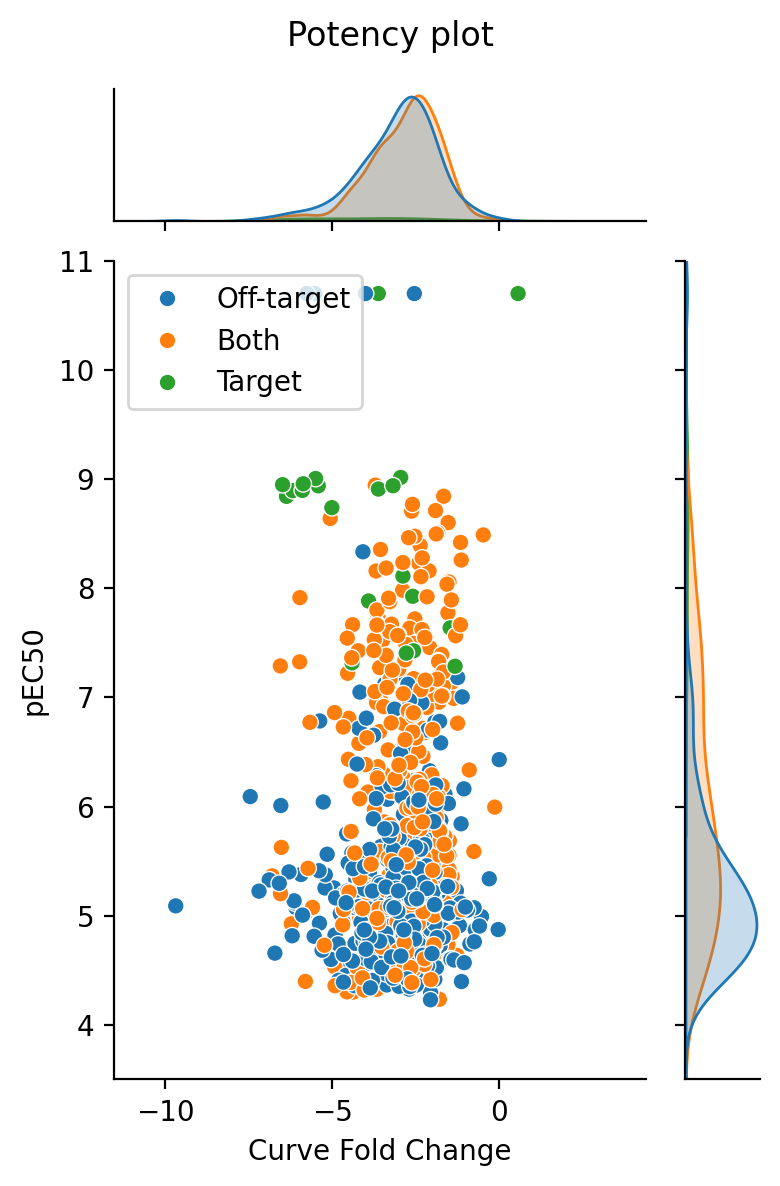

In [15]:
sns.jointplot(data=df_curvecurator, x="Curve Fold Change", y="pEC50", hue="Double fit type")
sns.despine()
plt.gcf().set_size_inches(4, 6)

# Move the title to above the density plot
plt.suptitle("Potency plot")
plt.tight_layout()

plt.legend(loc='upper left')
# Set ylim to 11
plt.ylim(3.5, 11)

## Check how the fit types are distributed across categories

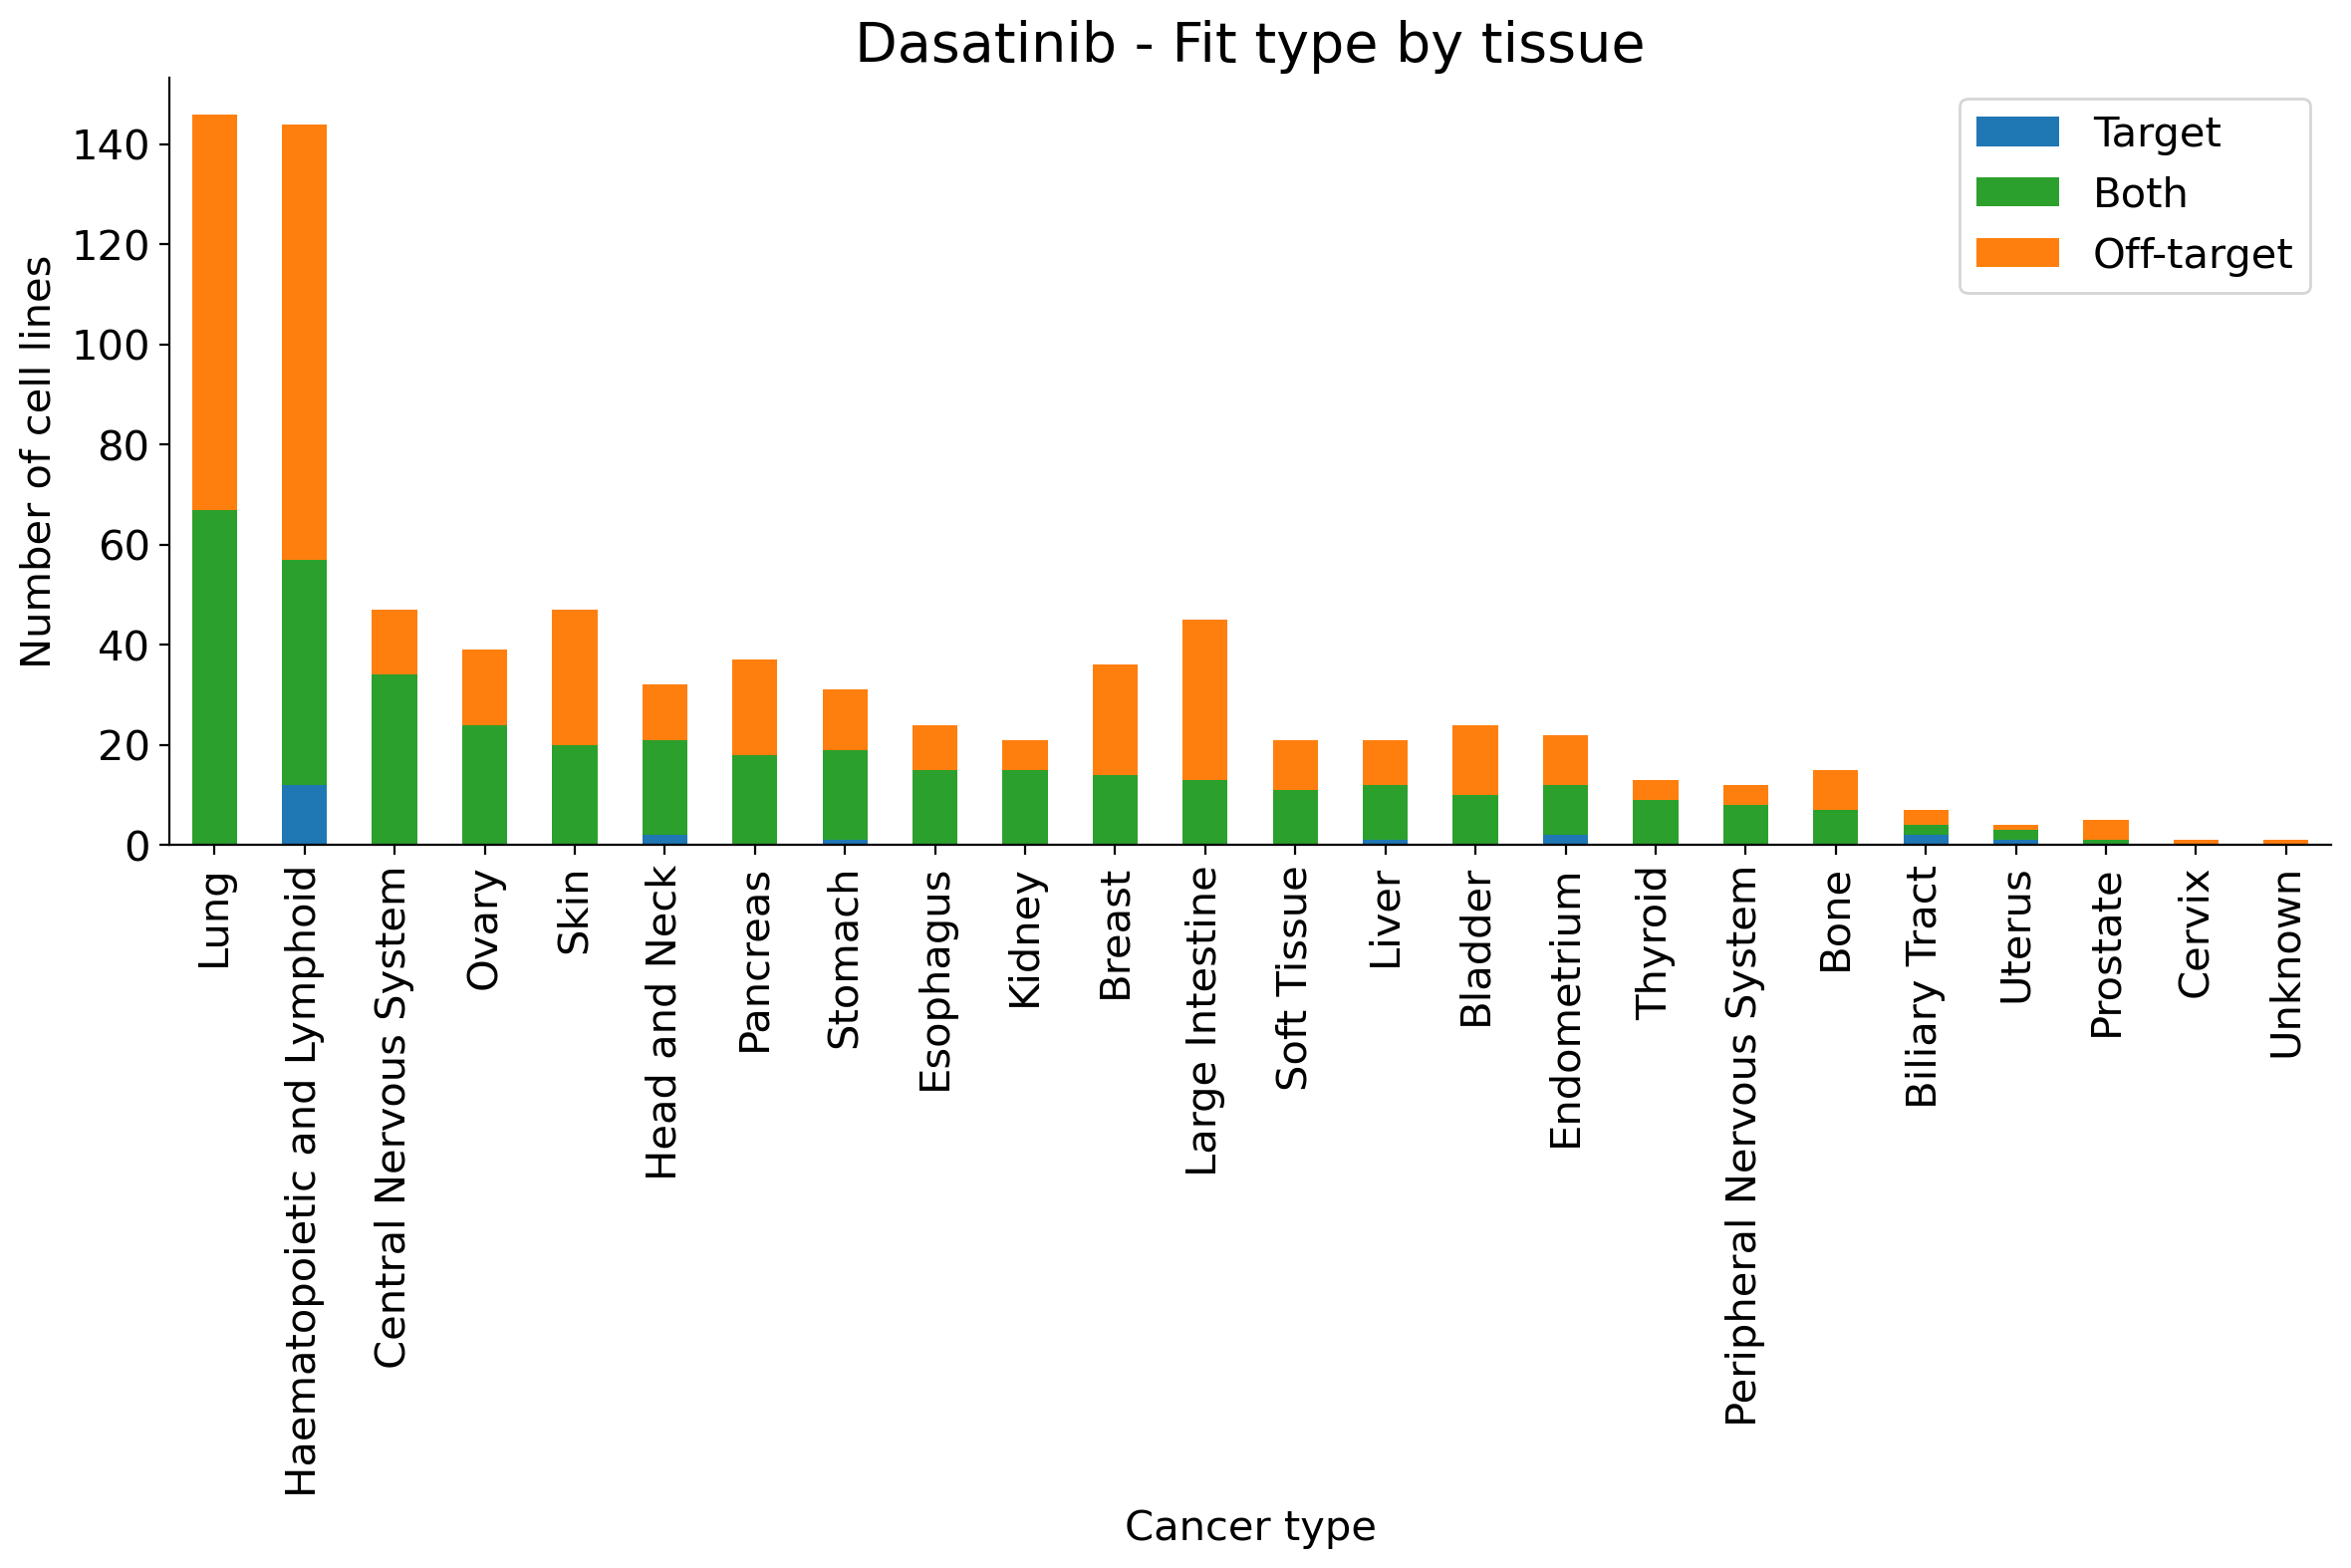

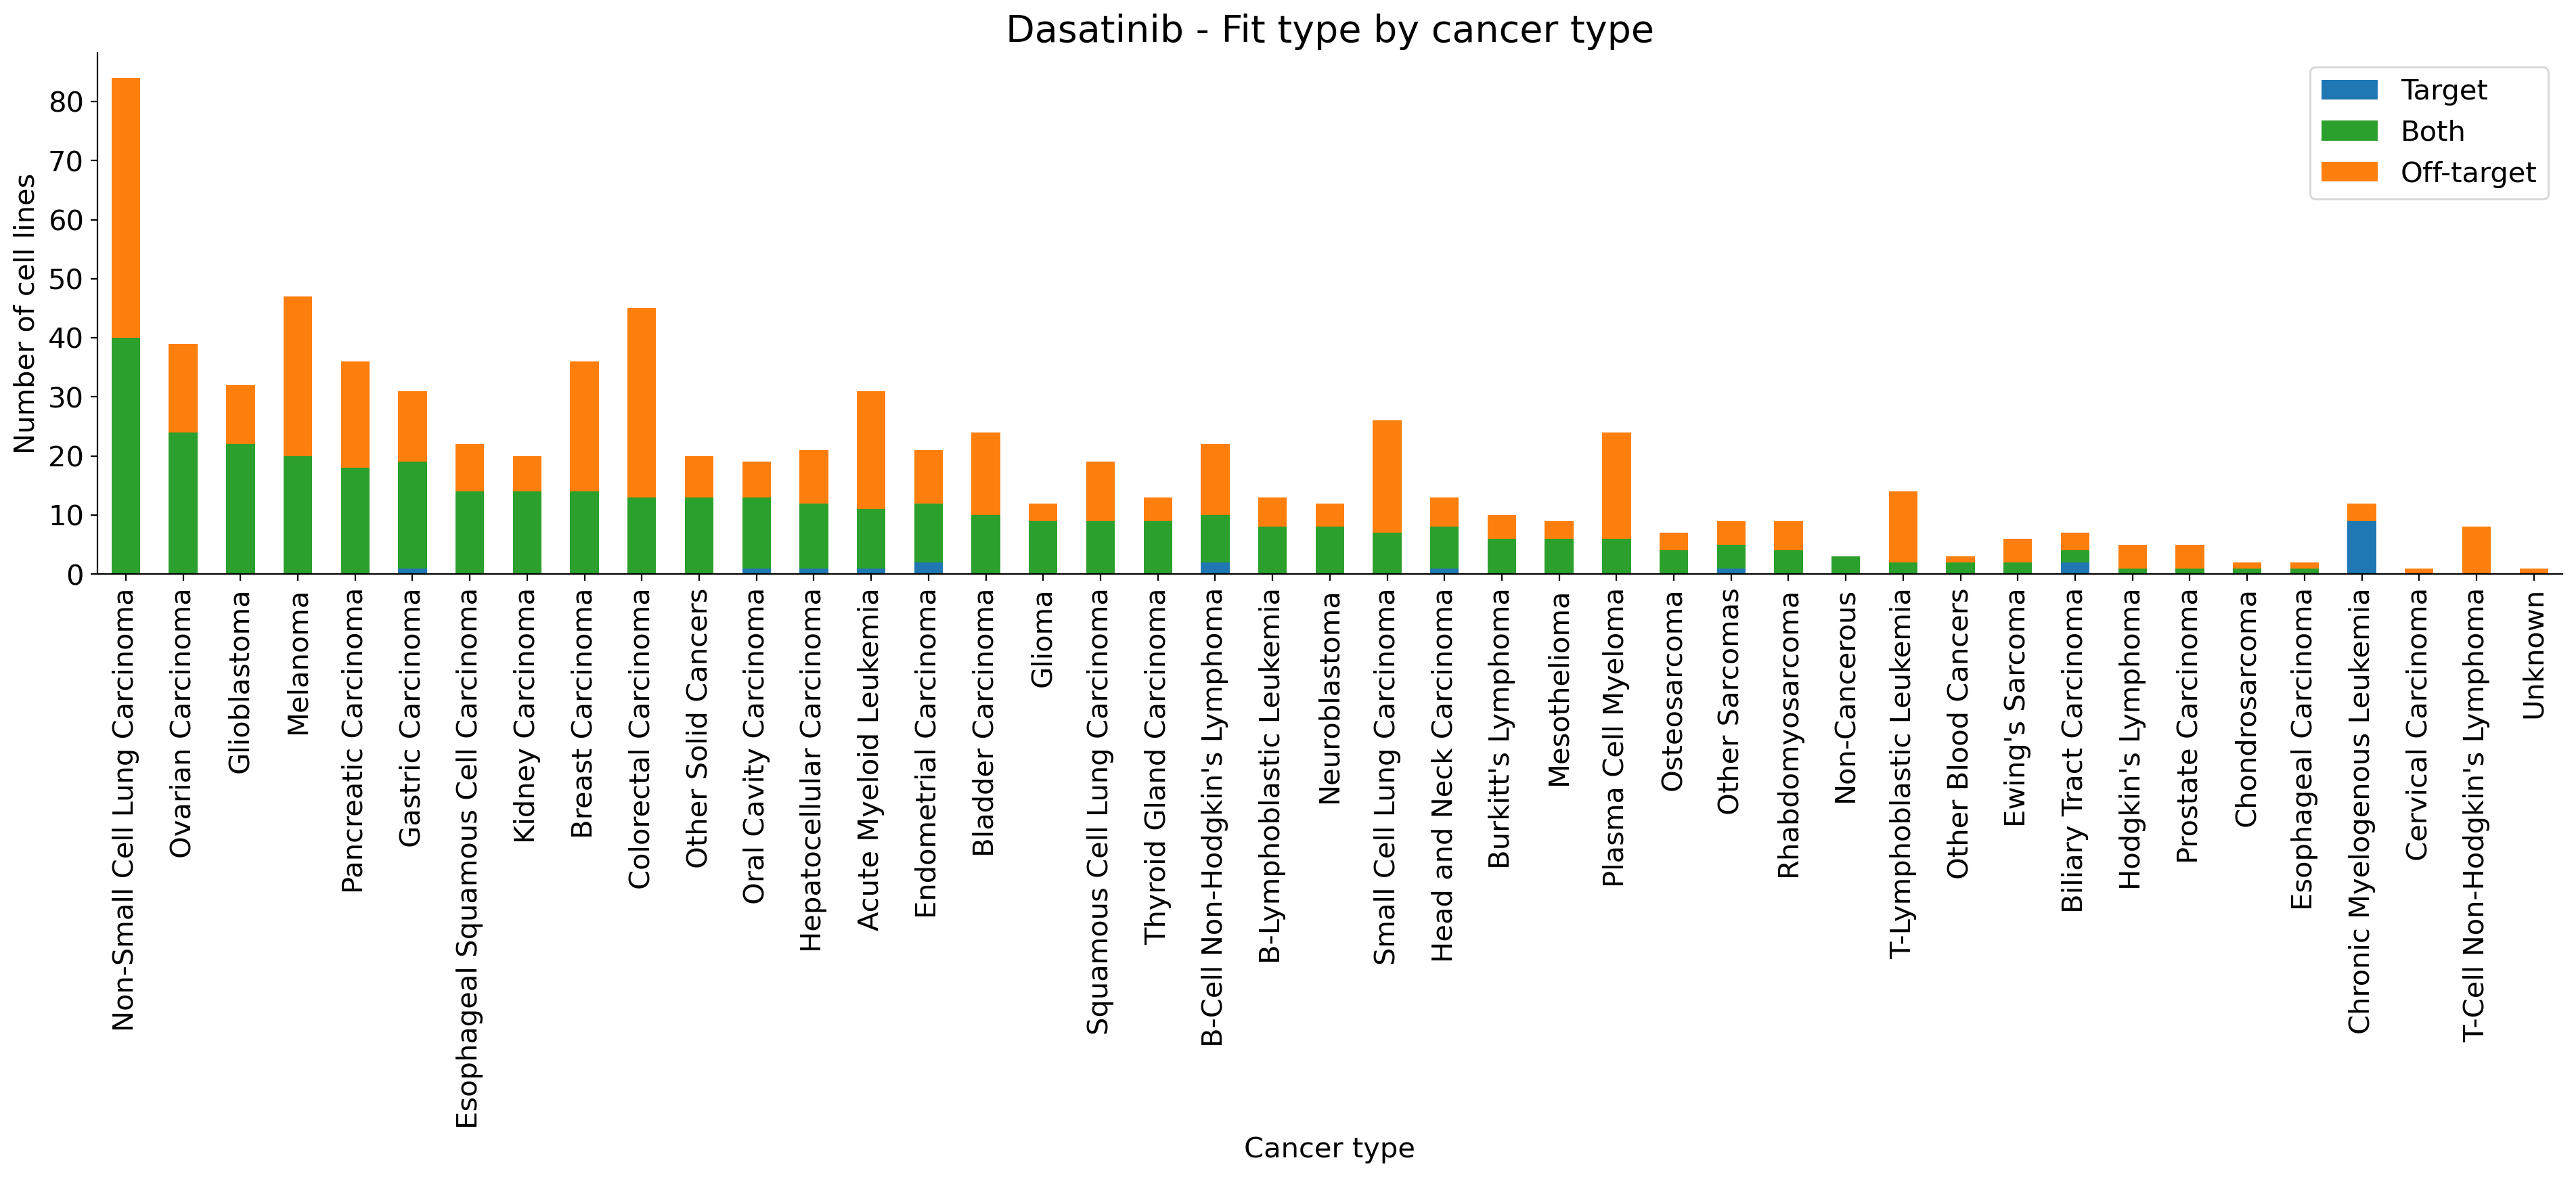

In [16]:
for category in ["tissue", "cancer_type"]:
    plot_fit_type(df_curvecurator, category, drug, palette)

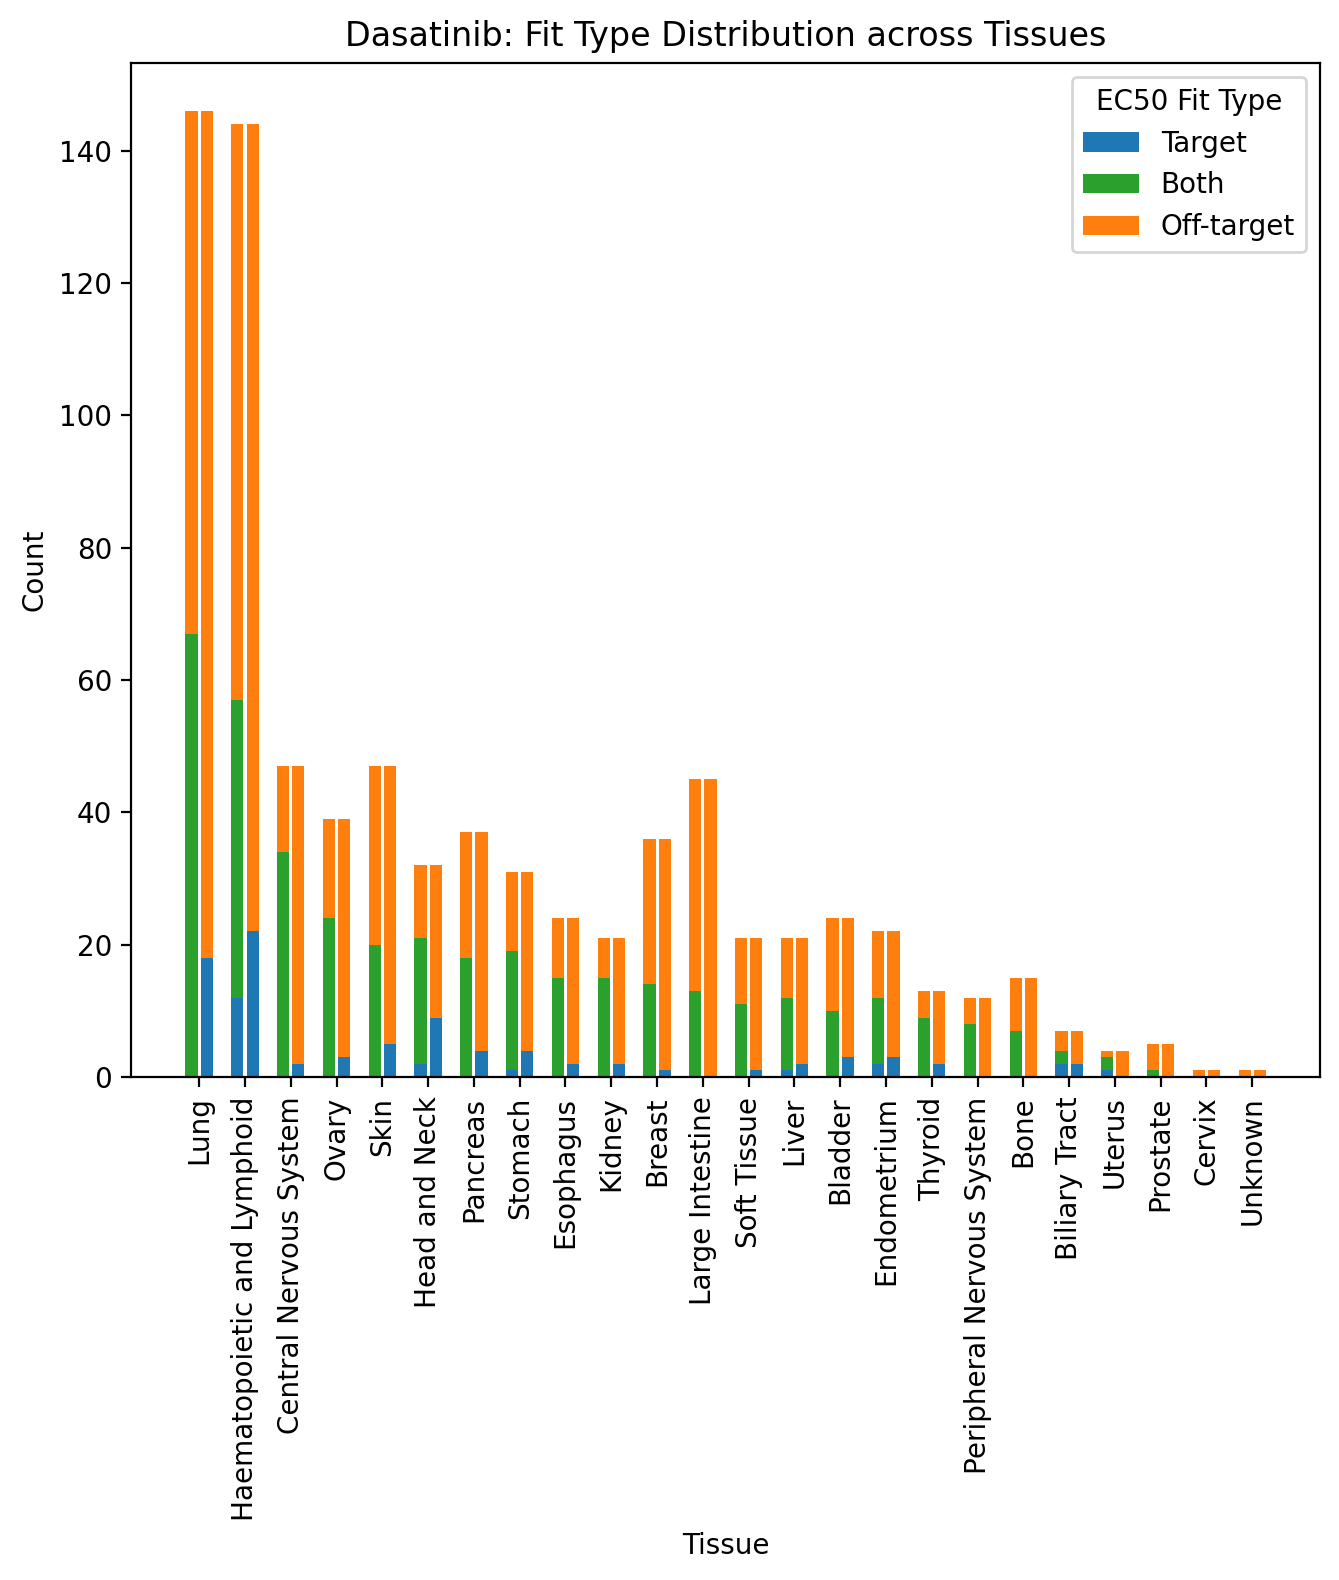

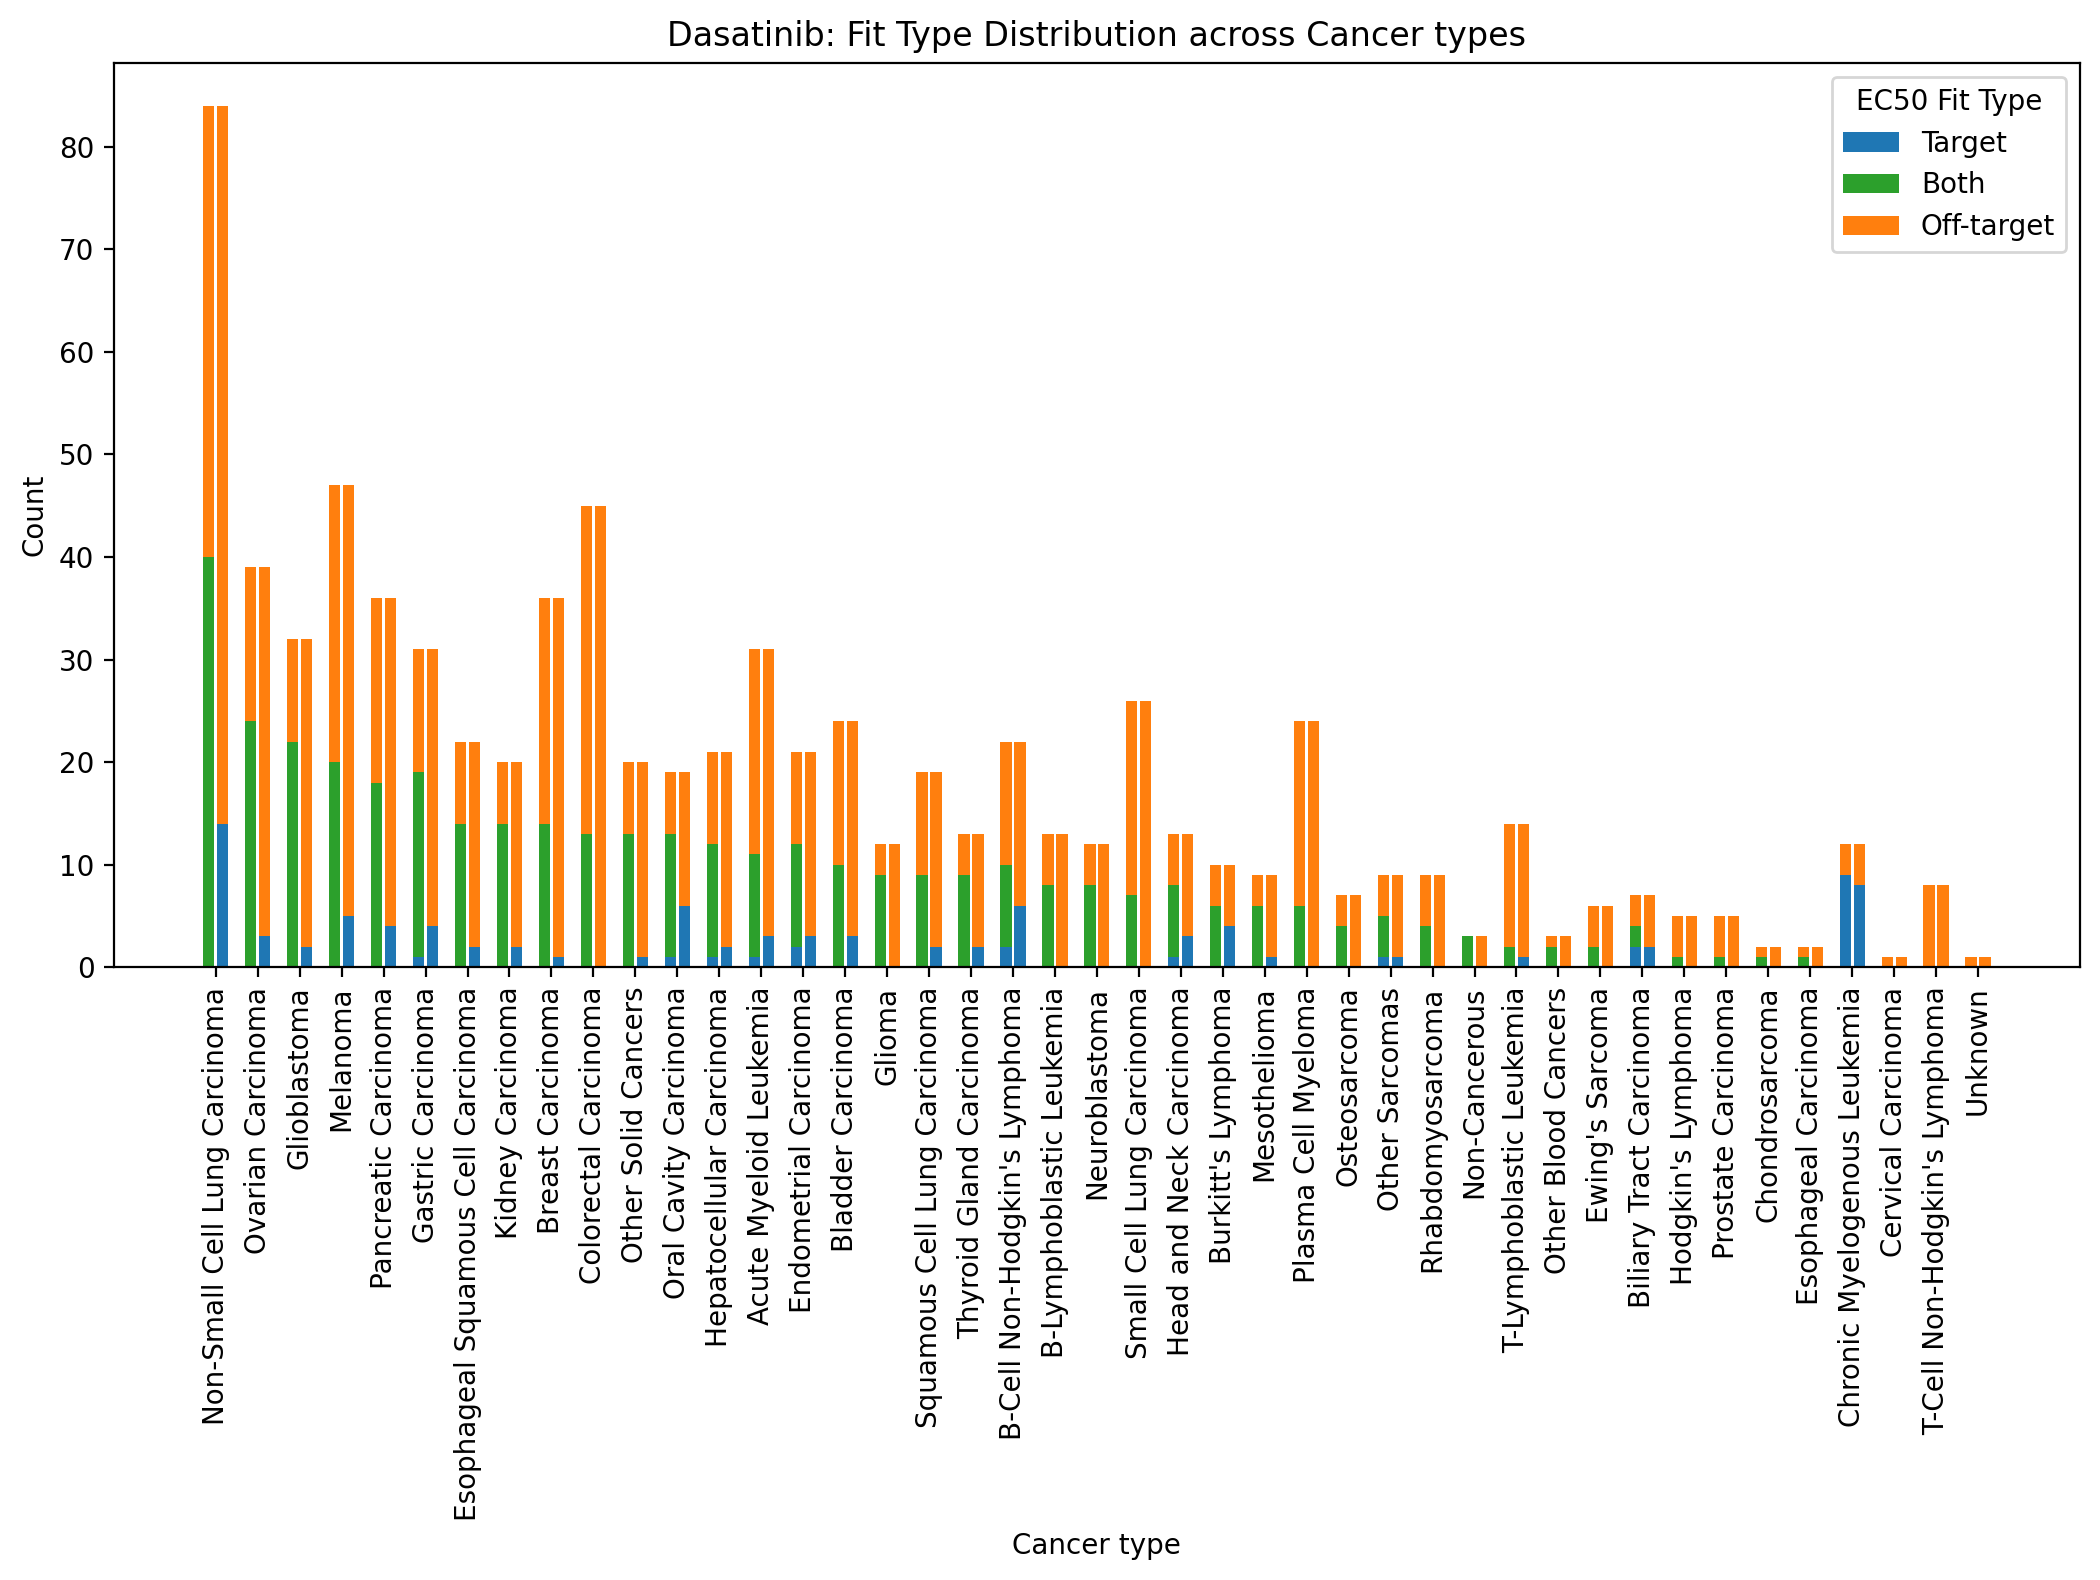

In [17]:
for category in ["tissue", "cancer_type"]:
    plot_paired_fit_type(df_curvecurator, category, drug, palette)

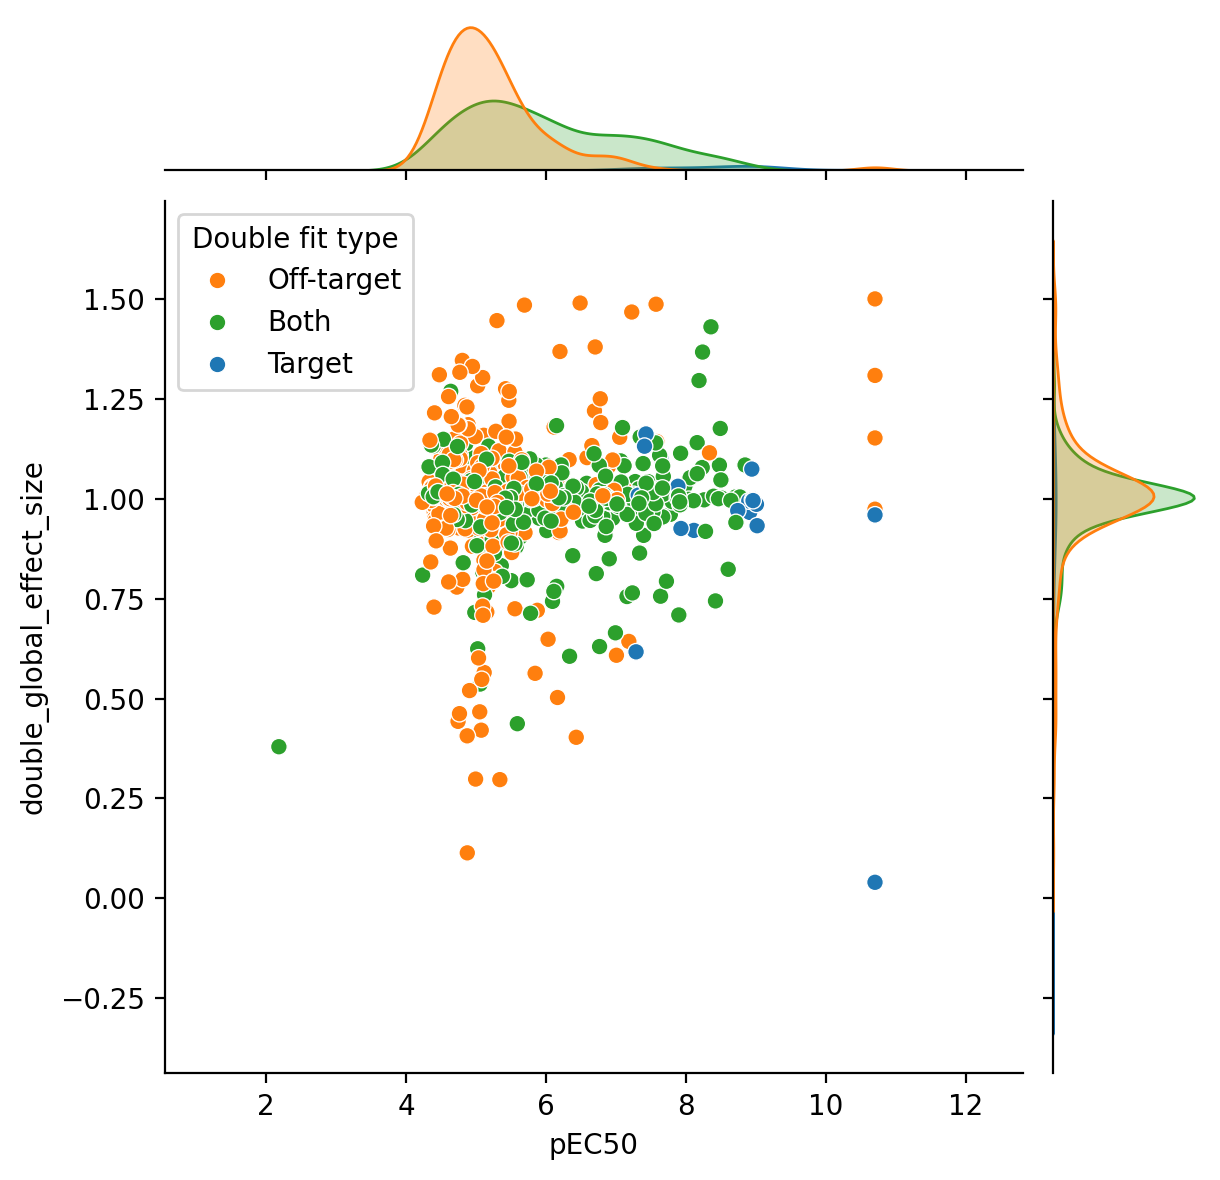

In [18]:
sns.jointplot(data=df_curvecurator, x="pEC50", y="double_global_effect_size", hue="Double fit type", palette=palette)